In [1]:
import os
import regex
import requests
import numpy as np
import pandas as pd
import json
import tweepy
from PIL import Image
from io import BytesIO
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from timeit import default_timer as timer

#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

# increase font size
plt.rcParams.update({'font.size': 14})

# Data Gathering

## Twitter Archiv
The twitter archiv is a file provided by udacity as startpoint. It is downloaded from [here](https://video.udacity-data.com/topher/2018/November/5bf60fbf_twitter-archive-enhanced/twitter-archive-enhanced.csv).\
Let's start and read the file into a data frame.

In [2]:
archiv_df = pd.read_csv('twitter-archive-enhanced.csv')
archiv_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
archiv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

The archiv data shows informations like tweet id, timestamp, text of the tweet and muh more what is not clear yet.
Let's go on with further provided data.


## Breed Classification data
Udacity provided a file where the breeds are classified, using a neural network. This file is to download programmatically.

In [4]:
# Udacity provided url
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

# Request url
response = requests.get(url)

# Write request content to file.
# Extract filename from url by split '/' and use the last one
with open(url.split('/')[-1], mode = 'wb') as file:
    file.write(response.content)



In [5]:
# Read file into DataFrame
prediction_df = pd.read_csv('image-predictions.tsv', sep='\t')
prediction_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


Here is a column description, provided by the udacity project description


* tweet_id is the last part of the tweet URL after "status/" → https://twitter.com/dog_rates/status/889531135344209921
* p1 is the algorithm's #1 prediction for the image in the tweet → golden retriever
* p1_conf is how confident the algorithm is in its #1 prediction → 95%
* p1_dog is whether or not the #1 prediction is a breed of dog → TRUE
* p2 is the algorithm's second most likely prediction → Labrador retriever
* p2_conf is how confident the algorithm is in its #2 prediction → 1%
* p2_dog is whether or not the #2 prediction is a breed of dog → TRUE
* p3 is the algorithm's third most likely prediction → Labrador retriever
* p3_conf is how confident the algorithm is in its #3 prediction → 1%
* p3_dog is whether or not the #3 prediction is a breed of dog → TRUE




## Twitter API data
The third gathering data part ist download data with the twitter API. Therefore it is necessary to create a twitter acount, than create a twitter developer account.



In [6]:
# consumer and access data provided from twitter developer page by creating new project
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

# Create an authentication handler with tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# Set Access Token and Secret to authentication handler
auth.set_access_token(access_token, access_secret)

# Create the API handler with authentication handler
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)


In [8]:


# Query Twitter's API for JSON data for each tweet ID in the Twitter archive\

count = 0
fails_dict = {}
start = timer()

# Save each tweet's returned JSON as a new line in a .txt file\
with open('tweet_json.txt', 'w') as outfile:

    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit\
    for i, tweet_id in enumerate(archiv_df.tweet_id):
        # Check Output what is alread done 
        print(str(i+1) + ": " + str(tweet_id))
        # Try except block for the case that a tweet_id is not available
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass

end = timer()

print(end - start)
print(fails_dict.keys())




1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Fail
262: 842846295480000512
Success
263: 842765311967449089
Success
264: 842535590457499648
Success
265: 842163532590374912
Success
266: 842115215311396866
Success
267: 841833993020538882
Success
268: 841680585030541313
Success
269: 841439858740625411
Success
270: 841320156043304961
Success
271: 841314665196081154
Success
272: 841077006473256960
Success
273: 840761248237133825
Success
274: 840728873075638272
Success
275: 840698636975636481
Success
276: 840696689258311684
Success
277: 840632337062862849
Success
278: 840370681858686976
Success
279: 840268004936019968
Success
280: 839990271299457024
Success
281: 839549326359670784
Success
282: 839290600511926273
Success
283: 839239871831150596
Success
284: 838952994649550848
Success
285: 838921590096166913
Success
286: 838916489579200512
Success
287: 838831947270979586
Success
288: 838561493054533637
Success
289: 838476387338051585
Success
290: 838201503651401729
Success
291: 838150277551247360
Success
292: 838085839343206401
Success
293

Success
519: 810657578271330305
Success
520: 810284430598270976
Success
521: 810254108431155201
Success
522: 809920764300447744
Success
523: 809808892968534016
Success
524: 809448704142938112
Success
525: 809220051211603969
Success
526: 809084759137812480
Success
527: 808838249661788160
Success
528: 808733504066486276
Success
529: 808501579447930884
Success
530: 808344865868283904
Success
531: 808134635716833280
Success
532: 808106460588765185
Success
533: 808001312164028416
Success
534: 807621403335917568
Success
535: 807106840509214720
Success
536: 807059379405148160
Success
537: 807010152071229440
Success
538: 806629075125202948
Success
539: 806620845233815552
Success
540: 806576416489959424
Success
541: 806542213899489280
Success
542: 806242860592926720
Success
543: 806219024703037440
Success
544: 805958939288408065
Success
545: 805932879469572096
Success
546: 805826884734976000
Success
547: 805823200554876929
Success
548: 805520635690676224
Success
549: 805487436403003392
Success


Success
776: 776201521193218049
Success
777: 776113305656188928
Success
778: 776088319444877312
Success
779: 775898661951791106
Success
780: 775842724423557120
Success
781: 775733305207554048
Success
782: 775729183532220416
Success
783: 775364825476165632
Success
784: 775350846108426240
Success
785: 775096608509886464
Fail
786: 775085132600442880
Success
787: 774757898236878852
Success
788: 774639387460112384
Success
789: 774314403806253056
Success
790: 773985732834758656
Success
791: 773922284943896577
Success
792: 773704687002451968
Success
793: 773670353721753600
Success
794: 773547596996571136
Success
795: 773336787167145985
Success
796: 773308824254029826
Success
797: 773247561583001600
Success
798: 773191612633579521
Success
799: 772877495989305348
Success
800: 772826264096874500
Success
801: 772615324260794368
Success
802: 772581559778025472
Success
803: 772193107915964416
Success
804: 772152991789019136
Success
805: 772117678702071809
Success
806: 772114945936949249
Success
807

Rate limit reached. Sleeping for: 678


Success
902: 758474966123810816
Success
903: 758467244762497024
Success
904: 758405701903519748
Success
905: 758355060040593408
Success
906: 758099635764359168
Success
907: 758041019896193024
Success
908: 757741869644341248
Success
909: 757729163776290825
Success
910: 757725642876129280
Success
911: 757611664640446465
Success
912: 757597904299253760
Success
913: 757596066325864448
Success
914: 757400162377592832
Success
915: 757393109802180609
Success
916: 757354760399941633
Success
917: 756998049151549440
Success
918: 756939218950160384
Success
919: 756651752796094464
Success
920: 756526248105566208
Success
921: 756303284449767430
Success
922: 756288534030475264
Success
923: 756275833623502848
Success
924: 755955933503782912
Success
925: 755206590534418437
Success
926: 755110668769038337
Success
927: 754874841593970688
Success
928: 754856583969079297
Success
929: 754747087846248448
Success
930: 754482103782404096
Success
931: 754449512966619136
Success
932: 754120377874386944
Success


Success
1154: 725729321944506368
Success
1155: 725458796924002305
Success
1156: 724983749226668032
Success
1157: 724771698126512129
Success
1158: 724405726123311104
Success
1159: 724049859469295616
Success
1160: 724046343203856385
Success
1161: 724004602748780546
Success
1162: 723912936180330496
Success
1163: 723688335806480385
Success
1164: 723673163800948736
Success
1165: 723179728551723008
Success
1166: 722974582966214656
Success
1167: 722613351520608256
Success
1168: 721503162398597120
Success
1169: 721001180231503872
Success
1170: 720785406564900865
Success
1171: 720775346191278080
Success
1172: 720415127506415616
Success
1173: 720389942216527872
Success
1174: 720340705894408192
Success
1175: 720059472081784833
Success
1176: 720043174954147842
Success
1177: 719991154352222208
Success
1178: 719704490224398336
Success
1179: 719551379208073216
Success
1180: 719367763014393856
Success
1181: 719339463458033665
Success
1182: 719332531645071360
Success
1183: 718971898235854848
Success
11

Success
1403: 699423671849451520
Success
1404: 699413908797464576
Success
1405: 699370870310113280
Success
1406: 699323444782047232
Success
1407: 699088579889332224
Success
1408: 699079609774645248
Success
1409: 699072405256409088
Success
1410: 699060279947165696
Success
1411: 699036661657767936
Success
1412: 698989035503689728
Success
1413: 698953797952008193
Success
1414: 698907974262222848
Success
1415: 698710712454139905
Success
1416: 698703483621523456
Success
1417: 698635131305795584
Success
1418: 698549713696649216
Success
1419: 698355670425473025
Success
1420: 698342080612007937
Success
1421: 698262614669991936
Success
1422: 698195409219559425
Success
1423: 698178924120031232
Success
1424: 697995514407682048
Success
1425: 697990423684476929
Success
1426: 697943111201378304
Success
1427: 697881462549430272
Success
1428: 697630435728322560
Success
1429: 697616773278015490
Success
1430: 697596423848730625
Success
1431: 697575480820686848
Success
1432: 697516214579523584
Success
14

Success
1652: 683498322573824003
Success
1653: 683481228088049664
Success
1654: 683462770029932544
Success
1655: 683449695444799489
Success
1656: 683391852557561860
Success
1657: 683357973142474752
Success
1658: 683142553609318400
Success
1659: 683111407806746624
Success
1660: 683098815881154561
Success
1661: 683078886620553216
Success
1662: 683030066213818368
Success
1663: 682962037429899265
Success
1664: 682808988178739200
Success
1665: 682788441537560576
Success
1666: 682750546109968385
Success
1667: 682697186228989953
Success
1668: 682662431982772225
Success
1669: 682638830361513985
Success
1670: 682429480204398592
Success
1671: 682406705142087680
Success
1672: 682393905736888321
Success
1673: 682389078323662849
Success
1674: 682303737705140231
Success
1675: 682259524040966145
Success
1676: 682242692827447297
Success
1677: 682088079302213632
Success
1678: 682059653698686977
Success
1679: 682047327939461121
Success
1680: 682032003584274432
Success
1681: 682003177596559360
Success
16

Rate limit reached. Sleeping for: 669


Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Success
1809: 676897532954456065
Success
1810: 676864501615042560
Success
1811: 676821958043033607
Success
1812: 676819651066732545
Success
1813: 676811746707918848
Success
1814: 676776431406465024
Success
1815: 676617503762681856
Success
1816: 676613908052996102
Success
1817: 676606785097199616
Success
1818: 676603393314578432
Success
1819: 676593408224403456
Success
1820: 676590572941893632
Success
1821: 676588346097852417
Success
1822: 676582956622721024
Success
1823: 676575501977128964
Success
1824: 676533798876651520
Success
1825: 676496375194980353
Success
1826: 676470639084101634
Success
1827: 676440007570247681
Success
1828: 676430933382295552
Success
1829: 676263575653122048
Success
1830: 676237365392908289
Success
1831: 676219687039057920
Success
18

Success
2051: 671497587707535361
Success
2052: 671488513339211776
Success
2053: 671486386088865792
Success
2054: 671485057807351808
Success
2055: 671390180817915904
Success
2056: 671362598324076544
Success
2057: 671357843010908160
Success
2058: 671355857343524864
Success
2059: 671347597085433856
Success
2060: 671186162933985280
Success
2061: 671182547775299584
Success
2062: 671166507850801152
Success
2063: 671163268581498880
Success
2064: 671159727754231808
Success
2065: 671154572044468225
Success
2066: 671151324042559489
Success
2067: 671147085991960577
Success
2068: 671141549288370177
Success
2069: 671138694582165504
Success
2070: 671134062904504320
Success
2071: 671122204919246848
Success
2072: 671115716440031232
Success
2073: 671109016219725825
Success
2074: 670995969505435648
Success
2075: 670842764863651840
Success
2076: 670840546554966016
Success
2077: 670838202509447168
Success
2078: 670833812859932673
Success
2079: 670832455012716544
Success
2080: 670826280409919488
Success
20

Success
2300: 667065535570550784
Success
2301: 667062181243039745
Success
2302: 667044094246576128
Success
2303: 667012601033924608
Success
2304: 666996132027977728
Success
2305: 666983947667116034
Success
2306: 666837028449972224
Success
2307: 666835007768551424
Success
2308: 666826780179869698
Success
2309: 666817836334096384
Success
2310: 666804364988780544
Success
2311: 666786068205871104
Success
2312: 666781792255496192
Success
2313: 666776908487630848
Success
2314: 666739327293083650
Success
2315: 666701168228331520
Success
2316: 666691418707132416
Success
2317: 666649482315059201
Success
2318: 666644823164719104
Success
2319: 666454714377183233
Success
2320: 666447344410484738
Success
2321: 666437273139982337
Success
2322: 666435652385423360
Success
2323: 666430724426358785
Success
2324: 666428276349472768
Success
2325: 666421158376562688
Success
2326: 666418789513326592
Success
2327: 666411507551481857
Success
2328: 666407126856765440
Success
2329: 666396247373291520
Success
23

For some of the tweet ids the API download failed. Likely they are deleted.


### Read the json file and create a DataFrame

Read the `tweet-json-full.txt` line by line with `json.loads(line)` to get the dictionary access functionality.
Following columns are selected.

Baseline:
* id as tweet_id
* retweet_count 
* favorite_count

Additionally:
* lang as language
* in_reply_to_status_id_str
* in_reply_to_user_id_str
* is_quote_status



In [7]:
with open('tweet_json.txt', 'r') as file:
    # Empty list of lson dictionarys to store each line as dict
    json_dicts = []
    # Read per line
    for line in file:
        # interpret lina as json for dictinary functionality
        tweet_data = json.loads(line)
        
        # Append the extended tweed_data to the json_dicts
        json_dicts.append(tweet_data)

# Create a data frame from the json_dicts        
api_df = pd.DataFrame(json_dicts)
api_df.head()        


,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN


In [8]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2331 non-null   object 
 1   id                             2331 non-null   int64  
 2   id_str                         2331 non-null   object 
 3   full_text                      2331 non-null   object 
 4   truncated                      2331 non-null   bool   
 5   display_text_range             2331 non-null   object 
 6   entities                       2331 non-null   object 
 7   extended_entities              2059 non-null   object 
 8   source                         2331 non-null   object 
 9   in_reply_to_status_id          77 non-null     float64
 10  in_reply_to_status_id_str      77 non-null     object 
 11  in_reply_to_user_id            77 non-null     float64
 12  in_reply_to_user_id_str        77 non-null     o

In [9]:
api_df.lang.value_counts()

en     2313
und       7
nl        3
in        3
eu        1
et        1
ro        1
tl        1
es        1
Name: lang, dtype: int64

In [10]:
api_df.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2197
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64

In [11]:
api_df['user'][0]

{'id': 4196983835,
 'id_str': '4196983835',
 'name': 'WeRateDogs®',
 'screen_name': 'dog_rates',
 'location': 'links and things ➜',
 'description': 'Your Only Source For Professional Dog Ratings Instagram and Facebook ➜ WeRateDogs partnerships@weratedogs.com ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀',
 'url': 'https://t.co/6ytGi24QCk',
 'entities': {'url': {'urls': [{'url': 'https://t.co/6ytGi24QCk',
     'expanded_url': 'http://campsite.bio/weratedogs',
     'display_url': 'campsite.bio/weratedogs',
     'indices': [0, 23]}]},
  'description': {'urls': []}},
 'protected': False,
 'followers_count': 9002878,
 'friends_count': 16,
 'listed_count': 6541,
 'created_at': 'Sun Nov 15 21:41:29 +0000 2015',
 'favourites_count': 145830,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': True,
 'verified': True,
 'statuses_count': 13644,
 'lang': None,
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': False,
 'profile_background_color': '000000',
 'profile_background_image_url': 'htt

The columns `id`, `retweet_count`, `favorite_count` are requested by project needs. additional I want to use the language column `lang` and the column `retweeted_status`. The column `retweeted_status` contains a Tweet object, when it is a retweet. Therefore this column is for later project needs necessary. From the `user` column I can extract additional columns `favourites_count` and `followers_count`.

In [12]:
api_df = api_df[['id', 'user', 'retweet_count', 'favorite_count', 'lang', 'retweeted_status']]
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                2331 non-null   int64 
 1   user              2331 non-null   object
 2   retweet_count     2331 non-null   int64 
 3   favorite_count    2331 non-null   int64 
 4   lang              2331 non-null   object
 5   retweeted_status  163 non-null    object
dtypes: int64(3), object(3)
memory usage: 109.4+ KB


In [13]:
api_df.head()

,id,user,retweet_count,favorite_count,lang,retweeted_status
0,892420643555336193,"{'id': 4196983835, 'id_str': '4196983835', 'na...",7328,34930,en,NaN
1,892177421306343426,"{'id': 4196983835, 'id_str': '4196983835', 'na...",5472,30243,en,NaN
2,891815181378084864,"{'id': 4196983835, 'id_str': '4196983835', 'na...",3620,22760,en,NaN
3,891689557279858688,"{'id': 4196983835, 'id_str': '4196983835', 'na...",7521,38191,en,NaN
4,891327558926688256,"{'id': 4196983835, 'id_str': '4196983835', 'na...",8085,36465,en,NaN


### Additional data wrangling  for language abbreviations

In [14]:
# url with language abbreviation code table
url = 'https://www.loc.gov/standards/iso639-2/php/code_list.php'

# Request url
response = requests.get(url)

# Create Soup with html5lib parser due to error in 'lxml'
soup = BeautifulSoup(response.text, 'html5lib')

# Get outer table
table = soup.find('table')

# Get Language table
table_2 = table.find('table')

# Parse the ps4 tag element to panda built in function read_html
language_df = pd.read_html(str(table_2))[0]

# Check output
language_df



,ISO 639-2 Code,ISO 639-1 Code,English name of Language,French name of Language,German name of Language
0,aar,aa,Afar,afar,Danakil-Sprache
1,abk,ab,Abkhazian,abkhaze,Abchasisch
2,ace,NaN,Achinese,aceh,Aceh-Sprache
3,ach,NaN,Acoli,acoli,Acholi-Sprache
4,ada,NaN,Adangme,adangme,Adangme-Sprache
...,...,...,...,...,...
502,znd,NaN,Zande languages,"zandé, langues",Zande-Sprachen
503,zul,zu,Zulu,zoulou,Zulu-Sprache
504,zun,NaN,Zuni,zuni,Zuñi-Sprache
505,zxx,NaN,No linguistic content; Not applicable,pas de contenu linguistique; non applicable,Kein linguistischer Inhalt


# Data Assessment
The data assessment comes after the gathering. In the data assessing step we search for quality and [tidiness](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) issues.

Quality issues are
* format
* missing data
* typo
* content
* ...

Tidiness issues are
* Data Organization
* Non descriptive columns labels
* two variables in one column
* ...


## Twitter Archiv

In [15]:
archiv_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [16]:
archiv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [17]:
archiv_df.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [18]:
archiv_df.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [19]:
archiv_df.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [20]:
archiv_df.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [21]:
archiv_df.name.value_counts()

None       745
a           55
Charlie     12
Cooper      11
Lucy        11
          ... 
Arya         1
Karll        1
Beya         1
Rupert       1
Danny        1
Name: name, Length: 957, dtype: int64

In [22]:
# Check for numerators below 10. Normally they should be over 10
# 'They're Good Dogs Brent' - From Project Description
# Can it be an error while extracting the ratings from text?
numerator_below_10 = archiv_df.query('rating_numerator < 10')

In [23]:
# How much
numerator_below_10.shape

(440, 17)

In [24]:
# Show the first entries
numerator_below_10.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,None,None,None,None
229,848212111729840128,NaN,NaN,2017-04-01 16:35:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jerry. He's doing a distinguished tong...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/848212111...,6,10,Jerry,None,None,None,None
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
387,826598799820865537,8.265984e+17,4.196984e+09,2017-02-01 01:11:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I was going to do 007/10, but the joke wasn't ...",NaN,NaN,NaN,NaN,7,10,None,None,None,None,None
462,817502432452313088,NaN,NaN,2017-01-06 22:45:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Herschel. He's slightly bi...,6.924173e+17,4.196984e+09,2016-01-27 18:42:06 +0000,https://twitter.com/dog_rates/status/692417313...,7,10,Herschel,None,None,pupper,None


In [25]:
archiv_df.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [26]:
for text in archiv_df[archiv_df.source == '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>'].text:
    print(text,'\n')

This is Seamus. He's very bad at entering pools. Still a very good boy tho 11/10 https://t.co/hfi264QwYM 

This is Bailey. She has mastered the head tilt. 11/10 rather h*ckin adorable https://t.co/urhl90ZE1O 

Vine will be deeply missed. This was by far my favorite one. 14/10 https://t.co/roqIxCvEB3 

This is Ralphy. His dreams were just shattered. Poor pupper. 13/10 it'll be ok Ralphy https://t.co/P0kSN6rT6H 

This is Arnie. He's afraid of his own bark. 12/10 would comfort https://t.co/ObT2tSxXit 

This is Reginald. He's one magical puppo. Aerodynamic af. 12/10 would catch https://t.co/t0cEeRbcXJ 

This is Balto. He's very content. Legendary tongue slippage. 12/10 would pet forever https://t.co/T7Jr4Gw4sC 

This is Combo. The daily struggles of being a doggo have finally caught up with him. 11/10 https://t.co/LOKrNo0OM7 

Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u 

Here's a doggo questioning his entire existence. 10/10 someone tell him he's a good boy  https://t.co/dV

In [27]:
for text in archiv_df[archiv_df.source == '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'].text:
    print(text,'\n')

This is Spanky. He was a member of the 2002 USA Winter Olympic speed skating team. Accomplished af. 12/10 https://t.co/7tlZPrePXd 

This is Jameson. He had a few too many in the name of freedom. I can't not respect that. 11/10 'Merica https://t.co/8zQvXM6pG5 

This is Beau. He's trying to keep his daddy from packing to leave for Annual Training. 13/10 and now I'm crying https://t.co/7JeDfQvzzI 

Meet Jax &amp; Jil. Jil is yelling the pledge of allegiance. If u cant take the freedom get out the kitchen Jax. 10/10s https://t.co/jrg29NDNhI 

Meet Piper. She's an airport doggo. Please return your tray table to its full pupright and locked position. 11/10 https://t.co/D17IAcetmM 

This is Bo. He emanates happiness. 12/10 I could cut the freedom with a knife https://t.co/c7LNFt39eR 

This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh 

This pupper is not coming inside until she catches a snowflake on her tongue. 11/10 the determination is palpable https://t.co/lvM

In [28]:
for text in archiv_df[archiv_df.source == '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>'].text:
    print(text,'\n')

Meet General. He wasn't content with the quality of his room. Requested to pupgrade, but was ignored. 14/10 look who just lost a customer https://t.co/NP5JW8LnmW 

This is Max. There's no way in h*ck you're taking his pacifier. Binky promises it's not happening. 13/10 very good stubborn boy https://t.co/9lVAqDEvZ5 

There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10  
https://t.co/dp5h9bCwU7 

I couldn't make it to the #WKCDogShow BUT I have people there on the ground relaying me the finest pupper pics possible. 13/10 for all https://t.co/jd6lYhfdH4 

Beebop and Doobert should start a band 12/10 would listen 

Some happy pupper news to share. 10/10 for everyone involved 
https://t.co/MefMAZX2uv 

You need to watch these two doggos argue through a cat door. Both 11/10 https://t.co/qEP31epKEV 

This is Kirby. His bowl weighs more than him. 12/10 would assist https://t.co/UlB2mzw3Xs 

This is Rocco. He's doing his best. 13/10 someone help him (IG: rocco_roni) ht

In [29]:
# Text for first entry
print('numerator',numerator_below_10.rating_numerator[45])
numerator_below_10.text[45]

numerator 5


'This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948'

In [30]:
# Check for denominators which are unequal to 10.
# Normally they should be 10
# Can it be an error while extracting the ratings from text?
denominator_unequal_10 = archiv_df.query('rating_denominator != 10')

In [31]:
denominator_unequal_10.shape

(23, 17)

In [32]:
denominator_unequal_10.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,30582082.0,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None


In [33]:
print('denominator',denominator_unequal_10.rating_denominator[313])
print(denominator_unequal_10.text[313])


denominator 0
@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho


In [34]:
index = archiv_df[archiv_df.in_reply_to_status_id.notnull()].index

for idx in index:
    print(archiv_df[archiv_df.in_reply_to_status_id.notnull()].loc[idx].text,'\n\n')

@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution 


@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s 


@RealKentMurphy 14/10 confirmed 


@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs 


@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10 


Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen 


@Marc_IRL pixelated af 12/10 


THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA 


@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10 


@dhmontgomery We also gave snoop dogg a 420/10 but 

The archive_df data frame have following issues:

#### Quality
* Not satisfactory dog names with a
* Missing values in dog column have none instead nan
* Missing values in doggo, pupper, puppo, floofer are none istead nan
* tweet_id is integer, because I do not want to calculate anything a string it should be a string.
* timestamp schould be format datetime
* ratings for numerator and denominator are wrong.
* expandend_urls is a redundant information, because it is a fixed sring 'https:// twitter .com/dog_rates/status/' + tweet_id.
* The column retweeted_status_id shows, that here is an retweet,  which are accordingly to project specifications are not to consider.
* The columns source shows that there are tweets to another platform called 'vine'. These tweets are to remove.
* Column source are not needed.
* Columns in_reply_to.. not needed.

#### Tidiness
* The columns doggo, pupper, puppo, floofer are from one variable dog_type and belongs in one column


## Prediction Data

In [49]:
prediction_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [50]:
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [51]:
prediction_df.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [52]:
prediction_df.jpg_url.duplicated().value_counts()

False    2009
True       66
Name: jpg_url, dtype: int64

In [53]:
prediction_df.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [54]:
prediction_df.p2_dog.value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [55]:
prediction_df.p3_dog.value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

In [56]:
#prediction_df.query('p1_dog == False and ')
prediction_df.query("p1_dog == False and p2_dog == False and p3_dog == False")

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,880935762899988482,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,street_sign,0.251801,False,umbrella,0.115123,False,traffic_light,0.069534,False
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False


In this prediction data frame I founf the following issues:

#### Quality
* 66 duplicate picture entries
* tweet_id is integer, because I do not want to calculate anything 
* There are 324 rows where all three predictions identified not a dog. This rows should be removed from the data set.
* The column img_num makes no sense. Remove it.
#### Tidiness

* The columns 'p1', 'p1_dog', 'p1_conf','p2', 'p2_dog', 'p2_conf','p3', 'p3_dog', 'p3_conf', should be grouped in two columns 'breed' and 'confidence'




## API Data

In [57]:
api_df.head()

,id,user,retweet_count,favorite_count,lang,retweeted_status
0,892420643555336193,"{'id': 4196983835, 'id_str': '4196983835', 'na...",7328,34930,en,NaN
1,892177421306343426,"{'id': 4196983835, 'id_str': '4196983835', 'na...",5472,30243,en,NaN
2,891815181378084864,"{'id': 4196983835, 'id_str': '4196983835', 'na...",3620,22760,en,NaN
3,891689557279858688,"{'id': 4196983835, 'id_str': '4196983835', 'na...",7521,38191,en,NaN
4,891327558926688256,"{'id': 4196983835, 'id_str': '4196983835', 'na...",8085,36465,en,NaN


In [58]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                2331 non-null   int64 
 1   user              2331 non-null   object
 2   retweet_count     2331 non-null   int64 
 3   favorite_count    2331 non-null   int64 
 4   lang              2331 non-null   object
 5   retweeted_status  163 non-null    object
dtypes: int64(3), object(3)
memory usage: 109.4+ KB


In [59]:
api_df.lang.value_counts()

en     2313
und       7
nl        3
in        3
eu        1
et        1
ro        1
tl        1
es        1
Name: lang, dtype: int64

In [60]:
non_en = api_df.query('lang != "en"')

non_en_ids = non_en.id

for tweet_id in non_en_ids:
    print(archiv_df.query('tweet_id == @tweet_id').text, '\n')


32    RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...
Name: text, dtype: object 

165    RT @dog_rates: Ohboyohboyohboyohboyohboyohboyo...
Name: text, dtype: object 

290    @markhoppus 182/10
Name: text, dtype: object 

409    @HistoryInPics 13/10
Name: text, dtype: object 

620    #ImWithThor 13/10\nhttps://t.co/a18mzkhTf6
Name: text, dtype: object 

870    Ohboyohboyohboyohboyohboyohboyohboyohboyohboyo...
Name: text, dtype: object 

982    Duuun dun... duuun dun... dunn  dun. dunn dun....
Name: text, dtype: object 

1080    @mount_alex3 13/10
Name: text, dtype: object 

1345    13/10 hero af\n@ABC
Name: text, dtype: object 

1523    12/10 @LightningHoltt
Name: text, dtype: object 

1659    aahhhhkslaldhwnxmzbbs 12/10 for being da smoos...
Name: text, dtype: object 

1666    NAAAAAAA ZAPENYAAAAA MABADI-CHIBAWAAA 12/10 ht...
Name: text, dtype: object 

1886    ER... MER... GERD 13/10 https://t.co/L1puJISV1a
Name: text, dtype: object 

1914    13/10\n@ABC7
Name: text, dtype: object 


In [61]:
api_df.describe()

,id,retweet_count,favorite_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,2579.880309,7292.861004
std,6.823170e+16,4363.325603,11328.256529
min,6.660209e+17,1.000000,0.000000
25%,6.782670e+17,524.000000,1261.500000
50%,7.182469e+17,1203.000000,3159.000000
75%,7.986692e+17,2985.000000,8914.500000
max,8.924206e+17,74020.000000,150046.000000


In [62]:
api_df.user[0]

{'id': 4196983835,
 'id_str': '4196983835',
 'name': 'WeRateDogs®',
 'screen_name': 'dog_rates',
 'location': 'links and things ➜',
 'description': 'Your Only Source For Professional Dog Ratings Instagram and Facebook ➜ WeRateDogs partnerships@weratedogs.com ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀',
 'url': 'https://t.co/6ytGi24QCk',
 'entities': {'url': {'urls': [{'url': 'https://t.co/6ytGi24QCk',
     'expanded_url': 'http://campsite.bio/weratedogs',
     'display_url': 'campsite.bio/weratedogs',
     'indices': [0, 23]}]},
  'description': {'urls': []}},
 'protected': False,
 'followers_count': 9002878,
 'friends_count': 16,
 'listed_count': 6541,
 'created_at': 'Sun Nov 15 21:41:29 +0000 2015',
 'favourites_count': 145830,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': True,
 'verified': True,
 'statuses_count': 13644,
 'lang': None,
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': False,
 'profile_background_color': '000000',
 'profile_background_image_url': 'htt

For the API data set the following issues are identified

#### Quality

* column name 'id' refers to the tweet_id and should be renamed to 'tweet_id' that it is harmonized with the other data sets.
* The language columns is not interesting. The few entries wich are not english contains some mysterious text. In general this column can be dropped
* From retweet_status I can see that there are 163 retweets, which are accordingly to project specifications are not to consider.
* The followers_count and the favourites_count are to extract from user column

#### Tidiness
* All assessed data sets have with the tweet_id a common key and belongs to one table because it is one investigation.


# Cleaning Data

In [63]:
prediction_copy = prediction_df.copy()
api_copy = api_df.copy()

## Twitter Archiv 
The archive_df data frame have following issues:

#### Quality
* ~~Not satisfactory dog names with a~~
* ~~Missing values in dog column have none instead nan~~
* ~~Missing values in doggo, pupper, puppo, floofer are none instead nan~~
* ~~tweet_id is integer, because I do not want to calculate anything a string it should be a string.~~
* ~~timestamp should be format datetime~~
* ~~ratings for numerator and denominator are wrong.~~
* ~~expandend_urls is a redundant information, because it is a fixed sring 'https:// twitter .com/dog_rates/status/' + tweet_id.~~
* ~~The columns source shows that there are tweets to another platform called 'vine'. These tweets are to remove.~~
* ~~Column source are not needed.~~
* ~~Columns in_reply_to.. not needed.~~



#### Tidiness
* ~~The columns doggo, pupper, puppo, floofer are from one variable dog_type and belongs in one column~~



In [64]:
# Create copys from data sets for cleaning
archiv_copy = archiv_df.copy()

#### Define
* Format column tweet_id to integer
* Format timestamp to datetime
#### Code

In [65]:
archiv_copy.tweet_id = archiv_copy.tweet_id.astype(str)
archiv_copy.timestamp = pd.to_datetime(archiv_copy.timestamp)


In [66]:
archiv_copy[['tweet_id', 'timestamp']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   tweet_id   2356 non-null   object             
 1   timestamp  2356 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 36.9+ KB


#### Define

* Drop retweet columns bases on retweed_status_id
* Drop expandend_urls

#### Code

In [67]:
archiv_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

In [68]:
drop_index = archiv_copy[archiv_copy.retweeted_status_id.notnull()].index
archiv_copy.drop(index=drop_index, inplace=True)

drop_columns = ['retweeted_status_id', 'retweeted_status_user_id', 
                'retweeted_status_timestamp', 'expanded_urls']

archiv_copy.drop(columns=drop_columns, inplace=True)

#### Test

In [69]:
archiv_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   object             
 1   in_reply_to_status_id  78 non-null     float64            
 2   in_reply_to_user_id    78 non-null     float64            
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   rating_numerator       2175 non-null   int64              
 7   rating_denominator     2175 non-null   int64              
 8   name                   2175 non-null   object             
 9   doggo                  2175 non-null   object             
 10  floofer                2175 non-null   object             
 11  pupper                 2175 non-null   object           

#### Define
* For columns doggo, pupper, puppo, floofer replace 'none' with np.nan
* The columns doggo, pupper, puppo, floofer group to column dog_type

#### Code

In [70]:
# Add columns and create column 'doc_type'
archiv_copy['dog_type'] = (archiv_copy.doggo + archiv_copy.floofer + archiv_copy.pupper + archiv_copy.puppo)

# Replace 'None' by '' empty string
archiv_copy.dog_type = archiv_copy.dog_type.str.replace('None', '')

# Replace empty string with np.nan
archiv_copy.dog_type.replace('', np.nan, inplace=True)

# Drop columns doggo, pupper, puppo, floofer
archiv_copy.drop(columns=['doggo', 'pupper', 'puppo', 'floofer'], inplace=True)


#### Test

In [71]:
archiv_copy.dog_type.value_counts()

pupper          224
doggo            75
puppo            24
doggopupper      10
floofer           9
doggofloofer      1
doggopuppo        1
Name: dog_type, dtype: int64

In [72]:
archiv_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   object             
 1   in_reply_to_status_id  78 non-null     float64            
 2   in_reply_to_user_id    78 non-null     float64            
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   rating_numerator       2175 non-null   int64              
 7   rating_denominator     2175 non-null   int64              
 8   name                   2175 non-null   object             
 9   dog_type               344 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(5)
memory usage: 186.9+ KB


Oops it seems that their are some dogs with two types. Doggofloofer and Doggopuppo. I want to keep this as a new dog type.

#### Define
Replace None strings in name column with np.nan

#### Code

In [73]:
index = archiv_copy.query('name == "None"').index
archiv_copy.loc[index, 'name'] = np.nan

#### Test

In [74]:
archiv_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   object             
 1   in_reply_to_status_id  78 non-null     float64            
 2   in_reply_to_user_id    78 non-null     float64            
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   rating_numerator       2175 non-null   int64              
 7   rating_denominator     2175 non-null   int64              
 8   name                   1495 non-null   object             
 9   dog_type               344 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(5)
memory usage: 266.9+ KB


#### Define
Figure out the names with a regular expression from the text column. Based on a tweet seen before the regex should be 'named' followed by whitespace one ore more followed by [0-9a-zA-Z] followed by .
#### Code

In [75]:
archiv_copy.query('name == "a"').text[1853]

"This is a Sizzlin Menorah spaniel from Brooklyn named Wylie. Lovable eyes. Chiller as hell. 10/10 and I'm out.. poof https://t.co/7E0AiJXPmI"

In [76]:
# Find the index where name is 'a'
index = archiv_copy.query('name == "a"').index
# Extract the name with regex
# nan if no regex matching
name_extract = archiv_copy.text[index].str.extract(r'named\s+(\w+)\.')[0]

# Assign the name series to the name column at the extracted indexes.
archiv_copy.loc[index, 'name'] = name_extract




#### Test

In [77]:
archiv_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   object             
 1   in_reply_to_status_id  78 non-null     float64            
 2   in_reply_to_user_id    78 non-null     float64            
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   rating_numerator       2175 non-null   int64              
 7   rating_denominator     2175 non-null   int64              
 8   name                   1458 non-null   object             
 9   dog_type               344 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(5)
memory usage: 266.9+ KB


#### Define 
* Extract the hole ranking new from the text.
* For the rows where 2 or more \d+/\d+ are extracted the user decides which is the ranking or which ranking is to keep.
* 

In [128]:
# Define regex for ranking pattern
regex = r'\d+/\d+'


# Add a column with the findings of regex pattern
archiv_copy['rating'] = archiv_copy.text.str.findall(regex)

# Overwrite the columns with new values
for idx in archiv_copy.index:
    archiv_copy.loc[idx, 'rating_numerator'] = archiv_copy.loc[idx, 'rating'][0].split('/')[0]
    archiv_copy.loc[idx, 'rating_denominator'] = archiv_copy.loc[idx, 'rating'][0].split('/')[1]

# Get the index where more than one rankings are
index = archiv_copy[archiv_copy.rating.str.len() != 1].index



In [129]:
for text in archiv_copy[archiv_copy.rating.str.len() != 1].text:
    print(text,'\n')

@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s 

@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho 

"Yep... just as I suspected. You're not flossing." 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ 

This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ 

After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ 

Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a 

This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq 

Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10
get it together Flurp https://t.co/Akzl5ynMmE 

This is Socks. That water pup w the super legs just splashed him. Socks did not 

In [130]:
# This commented Code block was used to let the user decide which of the rating patterns are to use.
# The Output is stored in the redefined variable
redefined = [2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]


# You can comment in the next lines of code to try it by yourself.

print('already done, don\'t touch')

## Loop through the entries with more than one ranking
## And ask for user input to define which ranking is tio use

#redefined = []
#for text in archiv_copy[archiv_copy.rating.str.len() != 1].text:
#    print(text,'\n')
#    choice = input('Please enter your choice 1, 2 or 3 if available or leave it blank if the tweet is not a rating\n\n')
#    try:
#        redefined.append(int(choice))
#    except:
#        denominators.append(-1)

already done, don't touch


In [131]:
# Update the rating values with the user selected rating
for i, idx in enumerate(index):
    archiv_copy.loc[idx, 'rating_numerator'] = archiv_copy.loc[idx, 'rating'][redefined[i]-1].split('/')[0]
    archiv_copy.loc[idx, 'rating_denominator'] = archiv_copy.loc[idx, 'rating'][redefined[i]-1].split('/')[1]  

In [132]:
# Set dtype for column to int
archiv_copy.rating_numerator = archiv_copy.rating_numerator.astype(int)
archiv_copy.rating_denominator = archiv_copy.rating_denominator.astype(int)
archiv_copy.describe()

,rating_numerator,rating_denominator
count,2082.000000,2082.000000
mean,12.849183,10.498559
std,44.129482,7.111810
min,1.000000,7.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [83]:
for text in archiv_copy.query('rating_numerator == 0').text:
    print(text, '\n')

When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag 

PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX 



After review of this two tweets I decide that this tweets are not ranking and drop these rows.

In [84]:
# Drop the rows with a null rating
drop_index = archiv_copy.query('rating_numerator == 0').index
archiv_copy.drop(index=drop_index, inplace=True)

In [85]:
# Drop the rating column, not longer needed
try:
    archiv_copy.drop(columns='rating', inplace=True)
except KeyError as ke:
    print(ke)

#### Test
* `describe()` to review min max of ratings
* `info()` to review column informations

In [86]:
archiv_copy.describe()

,in_reply_to_status_id,in_reply_to_user_id,rating_numerator,rating_denominator
count,7.700000e+01,7.700000e+01,2173.000000,2173.000000
mean,7.454900e+17,2.040329e+16,12.788311,10.477681
std,7.632197e+16,1.260797e+17,43.197108,6.961952
min,6.658147e+17,1.185634e+07,1.000000,7.000000
25%,6.757073e+17,2.918590e+08,10.000000,10.000000
50%,7.032559e+17,4.196984e+09,11.000000,10.000000
75%,8.265984e+17,4.196984e+09,12.000000,10.000000
max,8.862664e+17,8.405479e+17,1776.000000,170.000000


In [87]:
archiv_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2173 non-null   object             
 1   in_reply_to_status_id  77 non-null     float64            
 2   in_reply_to_user_id    77 non-null     float64            
 3   timestamp              2173 non-null   datetime64[ns, UTC]
 4   source                 2173 non-null   object             
 5   text                   2173 non-null   object             
 6   rating_numerator       2173 non-null   int64              
 7   rating_denominator     2173 non-null   int64              
 8   name                   1458 non-null   object             
 9   dog_type               344 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(5)
memory usage: 186.7+ KB


#### Define
Drop the reply columns, they are not used.

#### Code

In [88]:
archiv_copy.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id'], inplace=True)

#### Test

In [89]:
archiv_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2173 non-null   object             
 1   timestamp           2173 non-null   datetime64[ns, UTC]
 2   source              2173 non-null   object             
 3   text                2173 non-null   object             
 4   rating_numerator    2173 non-null   int64              
 5   rating_denominator  2173 non-null   int64              
 6   name                1458 non-null   object             
 7   dog_type            344 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(2), object(5)
memory usage: 152.8+ KB


#### Define
Remove vine tweets

#### Code

In [90]:
# Drop rows with source vine and drop the column source
drop_index = archiv_copy[archiv_copy.source == '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>'].index
archiv_copy.drop(index=drop_index, inplace=True)
archiv_copy.drop(columns='source', inplace=True)

#### Test

In [91]:
archiv_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2082 entries, 0 to 2355
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2082 non-null   object             
 1   timestamp           2082 non-null   datetime64[ns, UTC]
 2   text                2082 non-null   object             
 3   rating_numerator    2082 non-null   int64              
 4   rating_denominator  2082 non-null   int64              
 5   name                1413 non-null   object             
 6   dog_type            318 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 130.1+ KB


## Prediction Data
#### Quality

* ~~66 duplicate picture entries~~
* ~~tweet_id is integer, because I do not want to calculate anything~~
* ~~There are 324 rows where all three predictions identified not a dog. This rows should be removed from the data set.~~

#### Tidiness

* ~~The columns 'p1', 'p1_dog', 'p1_conf','p2', 'p2_dog', 'p2_conf','p3', 'p3_dog', 'p3_conf', should be grouped in two columns 'breed' and 'confidence'~~



In [92]:
# Create a copy for cleaning
prediction_copy = prediction_df.copy()
prediction_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### Define
Set dtype of tweet_id to int
#### Code

In [93]:
prediction_copy.tweet_id = prediction_copy.tweet_id.astype(str)

#### Test

In [94]:
prediction_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


#### Define
Remove duplicated jpeg_url rows
#### Code

In [95]:
# Search for duplicate and use inverse ~ 
prediction_copy = prediction_copy[~prediction_copy.jpg_url.duplicated()]

#### Test

In [96]:
prediction_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2009 non-null   object 
 1   jpg_url   2009 non-null   object 
 2   img_num   2009 non-null   int64  
 3   p1        2009 non-null   object 
 4   p1_conf   2009 non-null   float64
 5   p1_dog    2009 non-null   bool   
 6   p2        2009 non-null   object 
 7   p2_conf   2009 non-null   float64
 8   p2_dog    2009 non-null   bool   
 9   p3        2009 non-null   object 
 10  p3_conf   2009 non-null   float64
 11  p3_dog    2009 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 162.8+ KB


#### Define
Remove rows where all three predictions are False
#### Code

In [97]:
drop_index = prediction_copy.query('p1_dog == False and p2_dog == False and p3_dog == False').index
prediction_copy.drop(index=drop_index, inplace=True)

#### Test

In [98]:
prediction_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691 entries, 0 to 2073
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1691 non-null   object 
 1   jpg_url   1691 non-null   object 
 2   img_num   1691 non-null   int64  
 3   p1        1691 non-null   object 
 4   p1_conf   1691 non-null   float64
 5   p1_dog    1691 non-null   bool   
 6   p2        1691 non-null   object 
 7   p2_conf   1691 non-null   float64
 8   p2_dog    1691 non-null   bool   
 9   p3        1691 non-null   object 
 10  p3_conf   1691 non-null   float64
 11  p3_dog    1691 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 137.1+ KB


#### Define
 The idea for this concept comes from a LinkedIn Contact who has also done this course and he shared his [GitHub](https://github.com/DavidMachineLearning/data-analyst-udacity) Repository. My original plan was to create columns breed confidence prediction_loop. But after I see the concept from David I decide that this is a much better solution. Thanks to David. 
 

* Merge p1, p2, p3 columns in breed and confidence columns
* The columns p1_dog, p2_dog and p3_dog will be later removed
* Create column breed and confidence and prefill the columns with np.nan
* Do three loops
  1. Use all rows where p1_dog prediction is True
  2. Use all rows where p1_dog prediction is False but p2_dog is True
  3. Use all rows where p1_dog prediction is False, p2_dog is False but p3_dog is True
 


In [99]:


# Create a breed column and prefill the column with nan values
prediction_copy['breed'] = np.nan
# Create a confidence column and prefill the column with nan
prediction_copy['confidence'] = np.nan

# First prediction is a dog
# Create the index where dog is predicted
index = prediction_copy.query('p1_dog == True').index
# fill the breed column with the predicted dogs at index
prediction_copy.breed.loc[index] = prediction_copy.p1.loc[index]
# fill the rconfidence column with the confidence at index
prediction_copy.confidence.loc[index] = prediction_copy.p1_conf[index]

# First prediction is not a dog, second prediction is a dog
# Create the index where dog is predicted
index = prediction_copy.query('p1_dog == False and p2_dog == True').index
# fill the breed column with the predicted dogs at index
prediction_copy.breed.loc[index] = prediction_copy.p2.loc[index]
# fill the rconfidence column with the confidence at index
prediction_copy.confidence.loc[index] = prediction_copy.p2_conf[index]


# First and second prediction is not a dog, third prediction is a dog
# Create the index where dog is predicted
index = prediction_copy.query('p1_dog == False and p2_dog == False and p3_dog == True').index
# fill the breed column with the predicted dogs at index
prediction_copy.breed.loc[index] = prediction_copy.p3.loc[index]
# fill the rconfidence column with the confidence at index
prediction_copy.confidence.loc[index] = prediction_copy.p3_conf[index]



/Users/florian/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [100]:
# Drop columns
prediction_copy = prediction_copy[['tweet_id', 'jpg_url', 'breed', 'confidence']]


#### Test

In [101]:
prediction_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691 entries, 0 to 2073
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tweet_id    1691 non-null   object 
 1   jpg_url     1691 non-null   object 
 2   breed       1691 non-null   object 
 3   confidence  1691 non-null   float64
dtypes: float64(1), object(3)
memory usage: 146.1+ KB


## API Data

In [102]:
api_copy = api_df.copy()


#### Quality

* ~~column name 'id' refers to the tweet_id and should be renamed to 'tweet_id' that it is harmonized with the other data sets.~~
* ~~The language columns is not interesting. The few entries wich are not english contains some mysterious text. In general this column can be dropped~~
* ~~From retweet_status I can see that there are 163 retweets, which are accordingly to project specifications are not to consider.~~
* ~~The followers_count and the favourites_count are to extract from user column~~

#### Tidiness
* ~~The columns doggo, pupper, puppo, floofer are from one variable dog_type and belongs in one column~~


#### Define 
Rename id to tweet_id and set type to int
#### Code

In [103]:
api_copy.rename(columns={'id': 'tweet_id'}, inplace=True)
api_copy.tweet_id = api_copy.tweet_id.astype(str)

#### Test

In [104]:
api_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2331 non-null   object
 1   user              2331 non-null   object
 2   retweet_count     2331 non-null   int64 
 3   favorite_count    2331 non-null   int64 
 4   lang              2331 non-null   object
 5   retweeted_status  163 non-null    object
dtypes: int64(2), object(4)
memory usage: 109.4+ KB


#### Define
Drop lang column
#### Code

In [105]:
api_copy.drop(columns='lang', inplace=True)


#### Test

In [106]:
api_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2331 non-null   object
 1   user              2331 non-null   object
 2   retweet_count     2331 non-null   int64 
 3   favorite_count    2331 non-null   int64 
 4   retweeted_status  163 non-null    object
dtypes: int64(2), object(3)
memory usage: 91.2+ KB


#### Define
Remove the retweets from retweeted_status column
#### Code

In [107]:
api_copy = api_copy[api_copy.retweeted_status.isnull()]

In [108]:
api_copy.drop(columns='retweeted_status', inplace=True)

#### Test

In [109]:
api_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 0 to 2330
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2168 non-null   object
 1   user            2168 non-null   object
 2   retweet_count   2168 non-null   int64 
 3   favorite_count  2168 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 84.7+ KB


#### Define
Extract favorites_count and follower_count from user

* Create columns favorites_count and follower_count and prefill with np.nan


In [110]:
favourites = []
followers = []
for user_dict in api_copy.user:
    favourites.append(user_dict['favourites_count'])
    followers.append(user_dict['followers_count'])
api_copy['favourites_count'] = favourites
api_copy['followers_count'] = followers



In [111]:
api_copy.drop(columns='user',inplace=True)

#### Test



In [112]:
api_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 0 to 2330
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2168 non-null   object
 1   retweet_count     2168 non-null   int64 
 2   favorite_count    2168 non-null   int64 
 3   favourites_count  2168 non-null   int64 
 4   followers_count   2168 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 101.6+ KB


The previous defined cleaning steps are all done. Now it is time to merge all data into one dataframe.

#### Define

All datasets have a common key and belongs to the same analysis. Merge the dataf frames int one master data frame. Use panda `df_left.merge(df_right, on='tweet_id', how='inner')`. Use inner join, to match only rowns which are in all 3 datasets available.

#### Code

In [115]:
# Merge archiv_copy and api_copy to master
master_df = archiv_copy.merge(api_copy, on='tweet_id')
# Merge prediction_copy to master
master_df = master_df.merge(prediction_copy, on='tweet_id')

#### Test

In [116]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1678 entries, 0 to 1677
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1678 non-null   object             
 1   timestamp           1678 non-null   datetime64[ns, UTC]
 2   text                1678 non-null   object             
 3   rating_numerator    1678 non-null   int64              
 4   rating_denominator  1678 non-null   int64              
 5   name                1229 non-null   object             
 6   dog_type            259 non-null    object             
 7   retweet_count       1678 non-null   int64              
 8   favorite_count      1678 non-null   int64              
 9   favourites_count    1678 non-null   int64              
 10  followers_count     1678 non-null   int64              
 11  jpg_url             1678 non-null   object             
 12  breed               1678 non-null 

In [170]:
# Write the masster_df to csv
master_df.to_csv('twitter_archiv_master.csv')


# Analysis Data

* The most rated breeds
* The highest prediction confidence mean for breeds
* Rating numerator mean and medians for breeds
* Development favourites_count and followers_count for Wa Rate Dogs account.
* Retweet count mean per breed
* Favorite count mean per breed
* Correlation scatter plot between retweet_count and favorite_count


In [105]:
master_df = pd.read_csv('master_data.csv')
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1678 entries, 0 to 1677
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1678 non-null   int64  
 1   tweet_id            1678 non-null   int64  
 2   timestamp           1678 non-null   object 
 3   text                1678 non-null   object 
 4   rating_numerator    1678 non-null   int64  
 5   rating_denominator  1678 non-null   int64  
 6   name                1229 non-null   object 
 7   dog_type            259 non-null    object 
 8   retweet_count       1678 non-null   int64  
 9   favorite_count      1678 non-null   int64  
 10  favourites_count    1678 non-null   int64  
 11  followers_count     1678 non-null   int64  
 12  jpg_url             1678 non-null   object 
 13  breed               1678 non-null   object 
 14  confidence          1678 non-null   float64
dtypes: float64(1), int64(8), object(6)
memory usage: 196.8+

## The most rated breeds

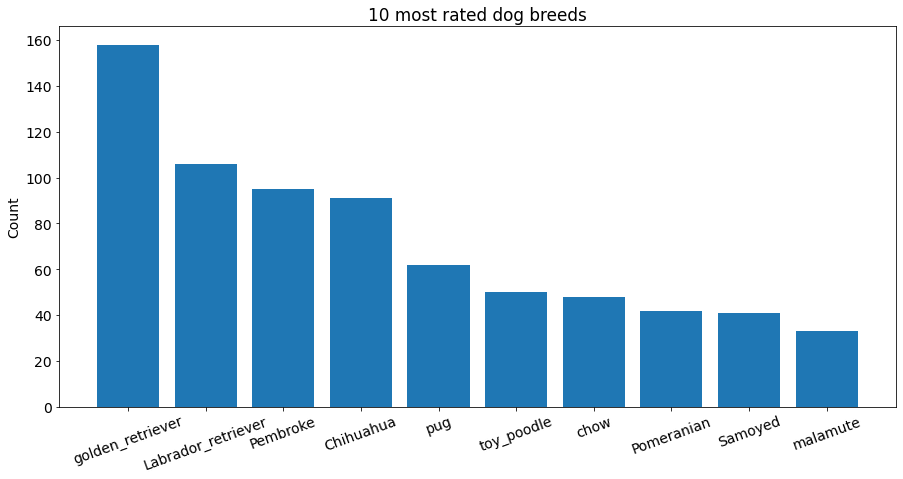

In [106]:
fig1, ax1 = plt.subplots(figsize=(15,7))
values = master_df.breed.value_counts()[:10]
breeds = values.index

ax1.bar(x=breeds, height=values)
ax1.set_title('10 most rated dog breeds')
ax1.set_ylabel('Count')
plt.xticks(rotation='20');
fig1.savefig('most_rated_breeds')
plt.show()

## The highest prediction confidence mean for breeds

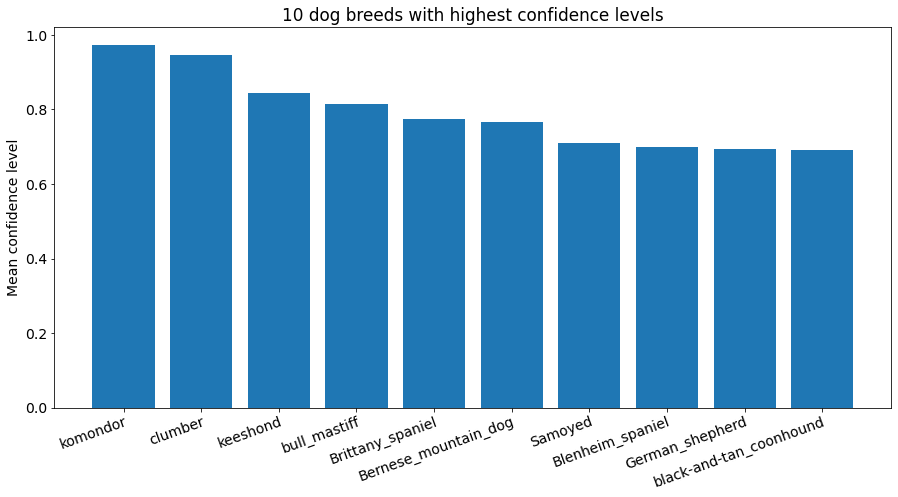

In [107]:
values = master_df.groupby('breed').confidence.mean().sort_values(ascending=False)[:10]
breeds = values.index

fig1, ax1 = plt.subplots(figsize=(15,7))

ax1.bar(x=breeds, height=values)
ax1.set_title('10 dog breeds with highest confidence levels')
ax1.set_ylabel('Mean confidence level')
plt.xticks(rotation='20', rotation_mode="anchor", ha="right");
fig1.savefig('highest_prediction_mean_breed', bbox_inches = 'tight')


## Rating numerator mean for breeds

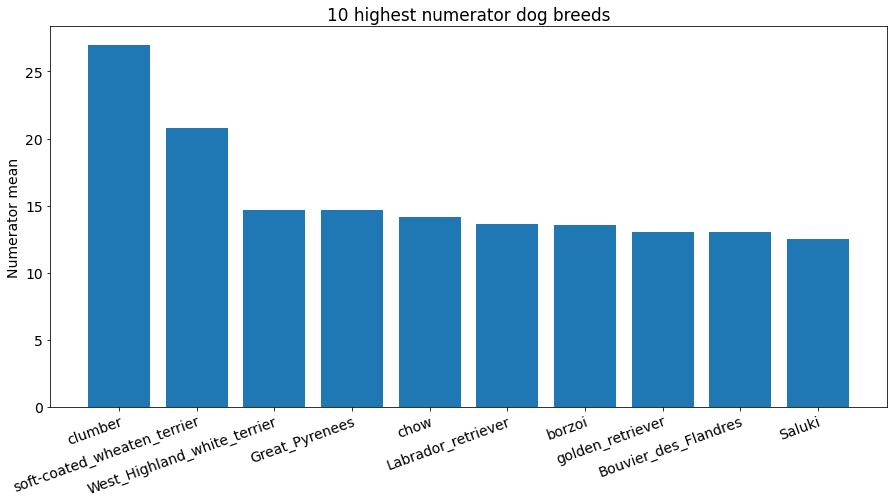

In [108]:
values_mean = master_df.groupby('breed').rating_numerator.mean().sort_values(ascending=False)[:10]
breeds_mean = values_mean.index

values_median = master_df.groupby('breed').rating_numerator.median().sort_values(ascending=False)[:10]
breeds_median = values_median.index

fig1, ax1 = plt.subplots(figsize=(15,7))

ax1.bar(x=breeds_mean, height=values_mean)
ax1.set_title('10 highest numerator dog breeds')
ax1.set_ylabel('Numerator mean')
plt.xticks(rotation='20', rotation_mode="anchor", ha="right");
fig1.savefig('insight1.png', bbox_inches = 'tight')




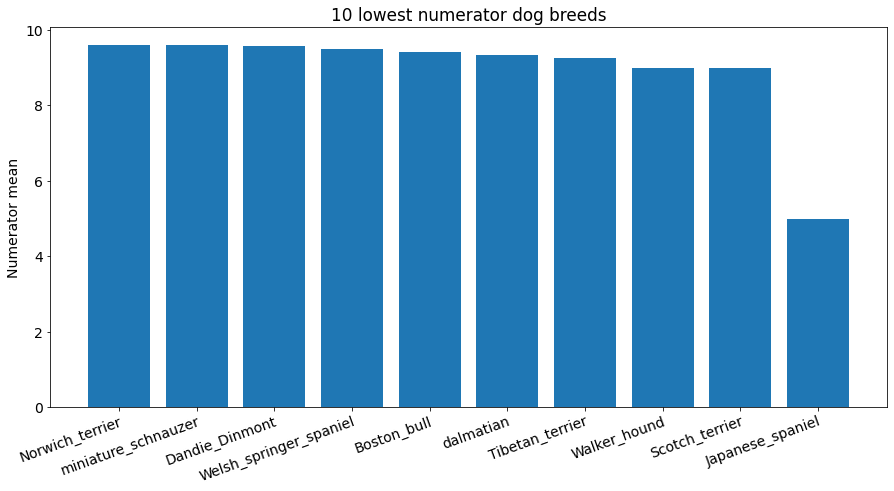

In [109]:
values_mean = master_df.groupby('breed').rating_numerator.mean().sort_values(ascending=False)[-10:]
breeds_mean = values_mean.index

values_median = master_df.groupby('breed').rating_numerator.median().sort_values(ascending=False)[:10]
breeds_median = values_median.index

fig1, ax1 = plt.subplots(figsize=(15,7))

ax1.bar(x=breeds_mean, height=values_mean)
ax1.set_title('10 lowest numerator dog breeds')
ax1.set_ylabel('Numerator mean')
plt.xticks(rotation='20', rotation_mode="anchor", ha="right");
fig1.savefig('insight2.png')

# Picture of lowest Japanese Spaniel rating

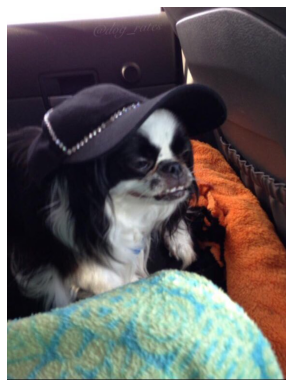

In [110]:
index = master_df.query('breed == "Japanese_spaniel"').rating_numerator.idxmin()

url = master_df.loc[index].jpg_url


response = requests.get(url)
image = Image.open(BytesIO(response.content))
plt.figure(figsize=(5, 7))
plt.imshow(image)
plt.axis("off")
plt.title = "The Undertaker!"
plt.savefig('The undertaker.png', bbox_inches = 'tight')
plt.show()


## Development favourites_count and followers_count for Wa Rate Dogs account.

In [111]:
master_df.describe()

,Unnamed: 0,tweet_id,rating_numerator,rating_denominator,retweet_count,favorite_count,favourites_count,followers_count,confidence
count,1678.000000,1.678000e+03,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1.678000e+03,1678.000000
mean,838.500000,7.389623e+17,11.470203,10.510727,2384.621573,8272.498212,145830.026818,9.002883e+06,0.549333
std,484.541192,6.789985e+16,8.059040,6.888295,4337.238541,12186.059064,0.306745,4.097617e+01,0.299065
min,0.000000,6.660209e+17,2.000000,7.000000,11.000000,69.000000,145829.000000,9.002876e+06,0.000010
25%,419.250000,6.773295e+17,10.000000,10.000000,538.500000,1869.750000,145830.000000,9.002878e+06,0.302321
50%,838.500000,7.127634e+17,11.000000,10.000000,1187.000000,3813.500000,145830.000000,9.002878e+06,0.548901
75%,1257.750000,7.930613e+17,12.000000,10.000000,2703.750000,10228.500000,145830.000000,9.002880e+06,0.821694
max,1677.000000,8.921774e+17,165.000000,150.000000,74020.000000,150046.000000,145833.000000,9.003233e+06,0.999956


The values for favourites_count and followers_count and the standard deviation for this distribution is som small compared to the size of values, that further investigations make no sense.

## Retweet count mean per breed

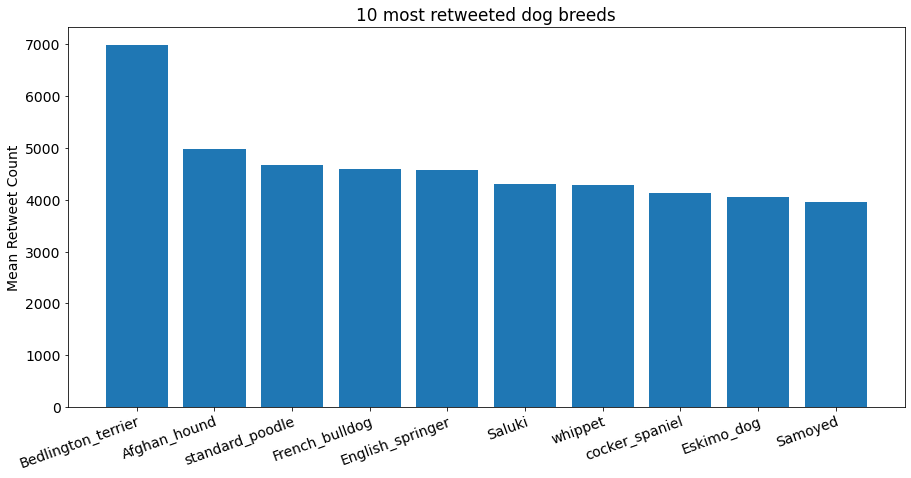

In [112]:
values = master_df.groupby('breed').retweet_count.mean().sort_values(ascending=False)[:10]
breeds = values.index

fig1, ax1 = plt.subplots(figsize=(15,7))

ax1.bar(x=breeds, height=values)
ax1.set_title('10 most retweeted dog breeds')
ax1.set_ylabel('Mean Retweet Count')
plt.xticks(rotation='20', rotation_mode="anchor", ha="right");
plt.savefig('most_retweeted_breeds.png', bbox_inches = 'tight')



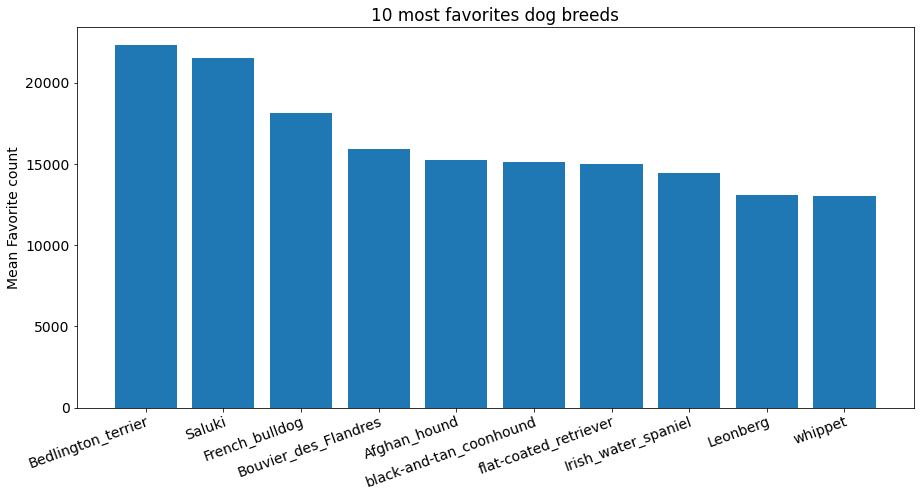

In [113]:
values = master_df.groupby('breed').favorite_count.mean().sort_values(ascending=False)[:10]
breeds = values.index

fig1, ax1 = plt.subplots(figsize=(15,7))

ax1.bar(x=breeds, height=values)
ax1.set_title('10 most favorites dog breeds')
ax1.set_ylabel('Mean Favorite count')
plt.xticks(rotation='20', rotation_mode="anchor", ha="right");
fig1.savefig('most_favorites_breeds.png', bbox_inches = 'tight')



## Correlation scatter plot between retweet_count and favorite_count

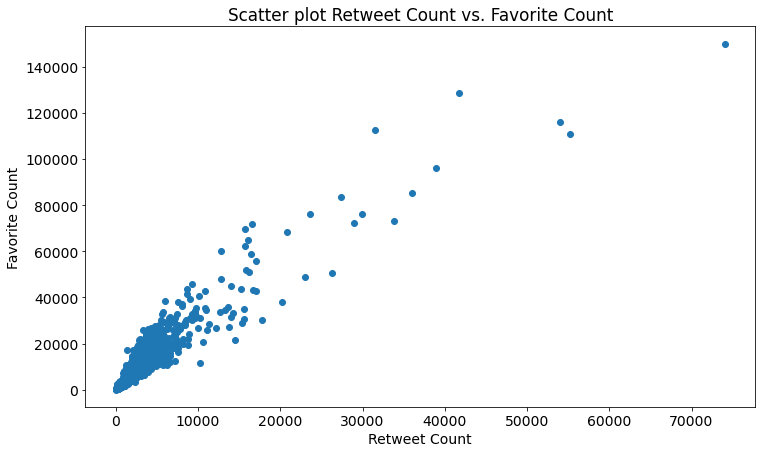

In [114]:
x = master_df.retweet_count
y = master_df.favorite_count

fig1, ax1 = plt.subplots(figsize=(12,7))

ax1.scatter(x, y)
ax1.set_title('Scatter plot Retweet Count vs. Favorite Count')
ax1.set_ylabel('Favorite Count')
ax1.set_xlabel('Retweet Count');

fig1.savefig('insight3.png', bbox_inches = 'tight')

